In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.formula.api as smf
from statsmodels.tsa.holtwinters import SimpleExpSmoothing 
from statsmodels.tsa.holtwinters import Holt 
from statsmodels.tsa.holtwinters import ExponentialSmoothing,HoltWintersResults
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error,mean_squared_error,root_mean_squared_error,mean_absolute_percentage_error

In [2]:
currency = pd.read_csv('exchange_rate.csv',parse_dates=True)
currency['date'] = pd.to_datetime(currency['date'], format="%d-%m-%Y %H:%M")
currency.set_index('date', inplace=True)
currency.head()

,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


In [3]:
currency.info()
# there are no null values

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB


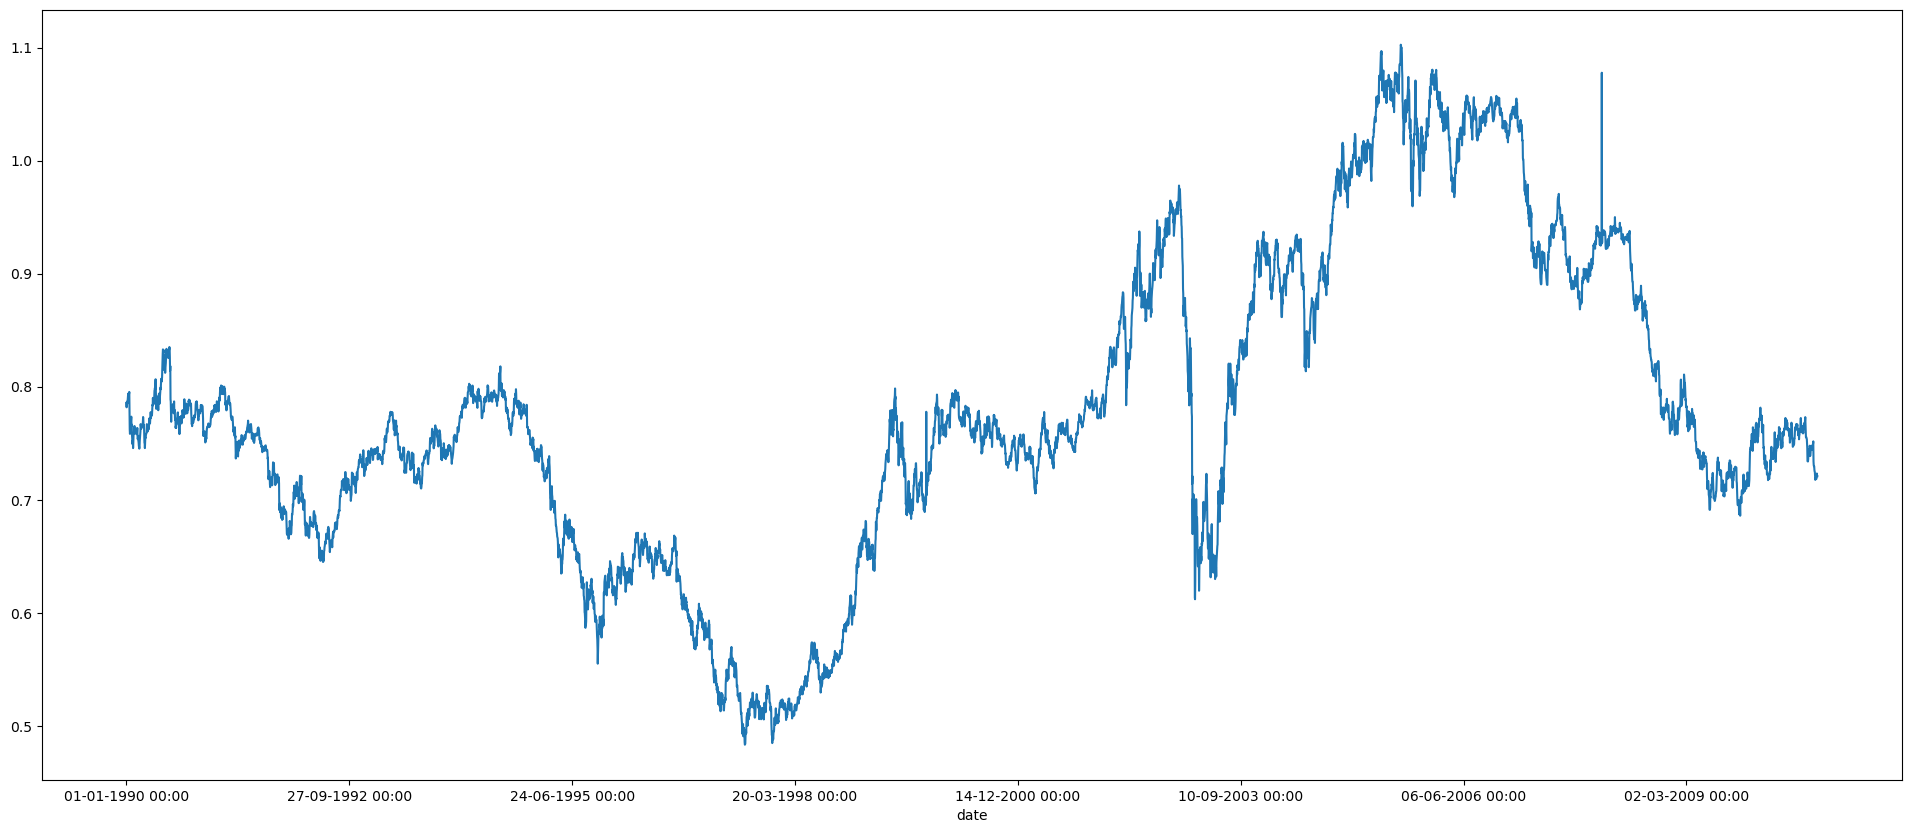

In [9]:
plt.figure(figsize=(24,10))
currency.Ex_rate.plot()
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x2a8791949b0>,
 'caps': [<matplotlib.lines.Line2D at 0x2a879194fe0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2a879194740>],
 'medians': [<matplotlib.lines.Line2D at 0x2a8791954c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2a8791957c0>],
 'means': []}

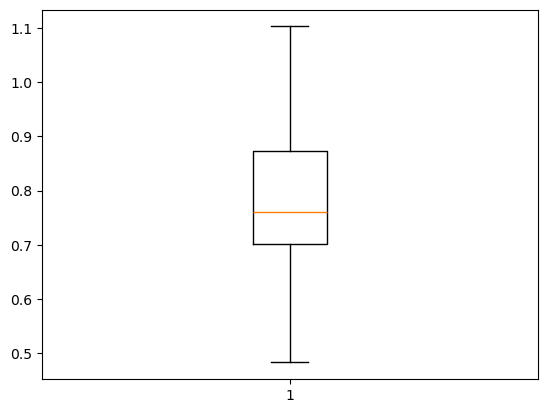

In [4]:
plt.boxplot(currency)

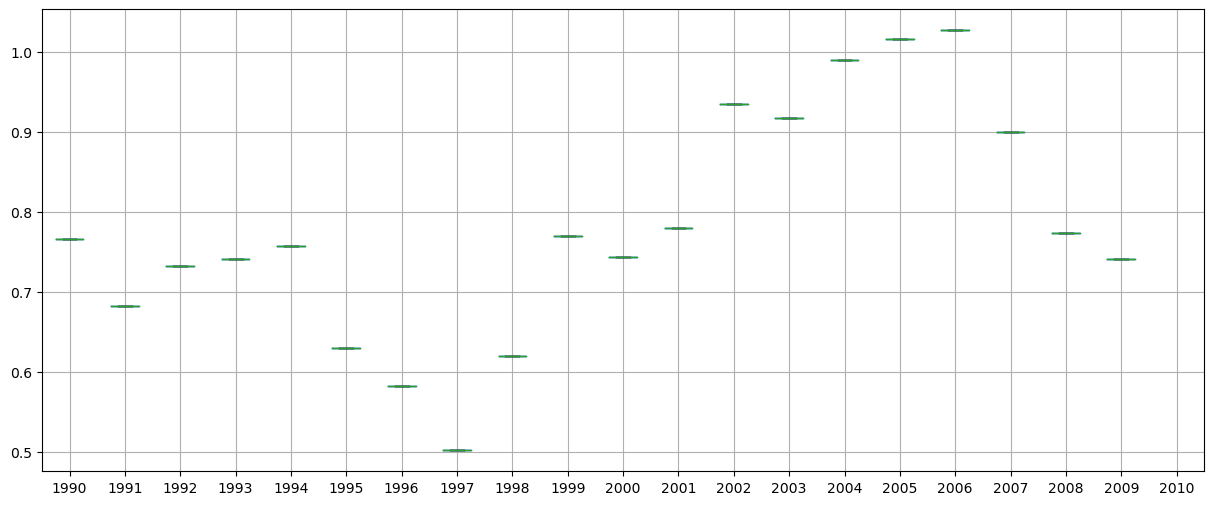

In [14]:
currency = pd.read_csv('exchange_rate.csv',parse_dates=True)
currency['date']= pd.to_datetime(currency.date,format="%d-%m-%Y %H:%M")
currency.set_index('date',inplace=True)
currency = currency.resample('M').mean()
groups = currency.groupby(pd.Grouper(freq='Y'))
years = pd.DataFrame()
for name, group in groups:
    group = group.reindex(pd.date_range(start=name, periods=12, freq='M'))
    years[name.year] = group.Ex_rate.values
plt.figure(figsize=(15,6))
years.boxplot()
plt.show()

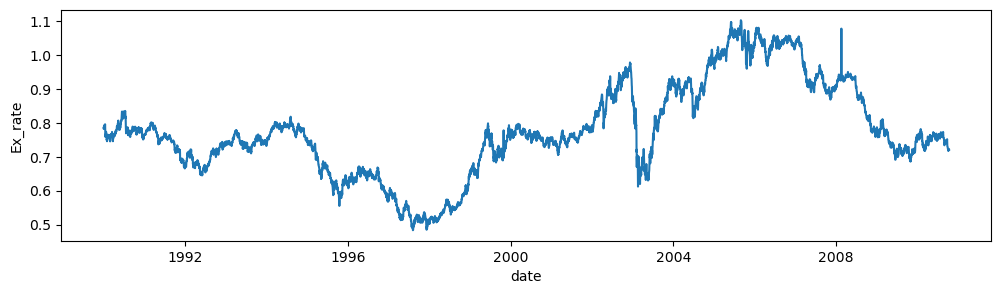

In [3]:
plt.figure(figsize=(12,3))
sns.lineplot(x=currency.index,y="Ex_rate",data=currency) 
plt.show()

<Figure size 2400x300 with 0 Axes>

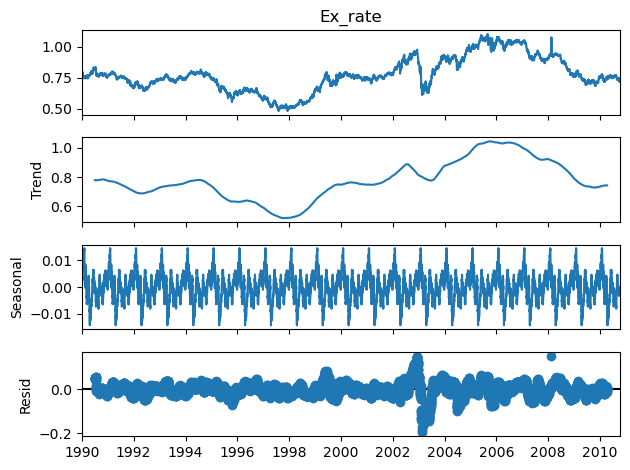

In [9]:
plt.figure(figsize=(24,3))
decompose_ts_add = seasonal_decompose(currency.Ex_rate,period=365)# yearly seasonality(pattern repeating every year)
decompose_ts_add.plot()
plt.show() 

* From the above plots it is clear that the data has level,Trend,Seasonality

# ADFULLER TEST for Stationarity

In [6]:
from statsmodels.tsa.stattools import adfuller

In [7]:
adfuller(currency.Ex_rate.values,regresults=True)

(-1.6649941807381414,
 0.4492327353597959,
 {'1%': -3.4312123140180137,
  '5%': -2.861921078147796,
  '10%': -2.5669728434336108},
 <statsmodels.stats.diagnostic.ResultsStore at 0x284eaccec50>)

* P-value = 0.44 i.e > 0.05 i.e test says that the data is not stationary

### making my data stationary

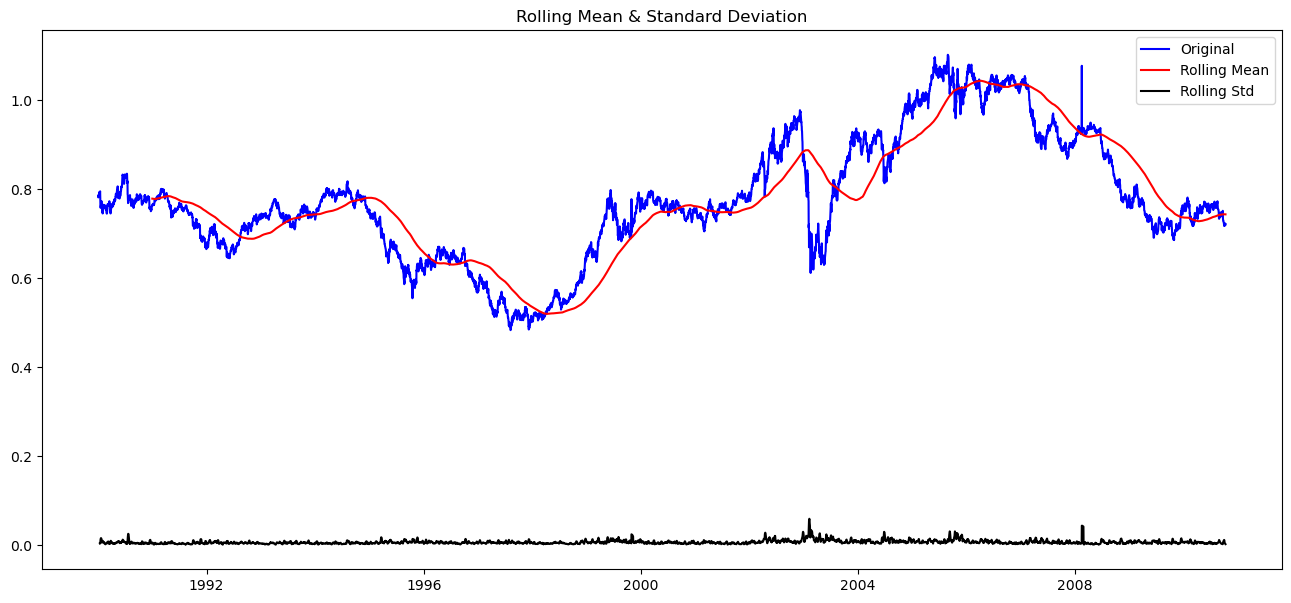

In [11]:
#Determing rolling statistics
rolLmean = currency.rolling(365).mean()
rolLstd = currency.rolling(12).std()

plt.figure(figsize=(16,7))
fig = plt.figure(1)

#Plot rolling statistics:
orig = plt.plot(currency, color='blue',label='Original')
mean = plt.plot(rolLmean, color='red', label='Rolling Mean')
std = plt.plot(rolLstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

In [15]:
# Assuming 'currency' DataFrame is loaded correctly
currency = pd.read_csv('exchange_rate.csv', parse_dates=True)
currency['date'] = pd.to_datetime(currency['date'], format="%d-%m-%Y %H:%M")
currency.set_index('date', inplace=True)

# Resample to monthly frequency and take the mean
currency = currency.resample('M').mean()

# Group by year and check the number of months in each year
groups = currency.groupby(pd.Grouper(freq='Y'))

# Initialize an empty list to store years with fewer than 12 months
incomplete_years = []

for name, group in groups:
    if len(group) < 12:  # Check if there are fewer than 12 months
        incomplete_years.append((name.year, len(group)))

# Display the years with fewer than 12 months and the number of months they contain
print("Years with fewer than 12 months:")
for year, month_count in incomplete_years:
    print(f"Year: {year}, Months: {month_count}")

Years with fewer than 12 months:
Year: 2010, Months: 10


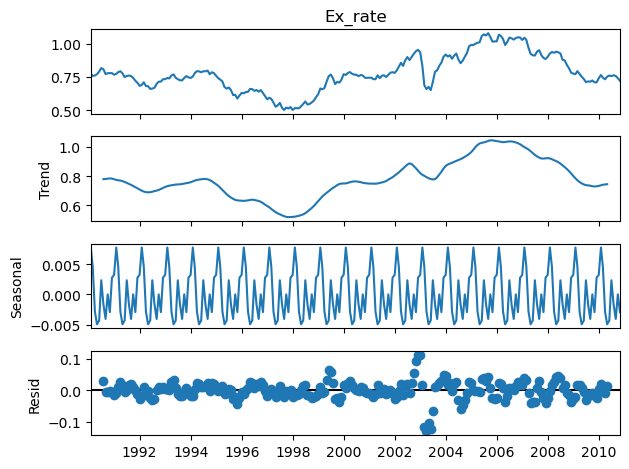

In [47]:
currency = pd.read_csv('exchange_rate.csv', parse_dates=True)
currency['date'] = pd.to_datetime(currency['date'], format="%d-%m-%Y %H:%M")
currency.set_index('date', inplace=True)
down_sample= currency.resample('M').mean()
decomposition = seasonal_decompose(down_sample.Ex_rate, model='additive', period=12)# period 12 means anual seasonality

# Plot decomposition
decomposition.plot()
plt.show()

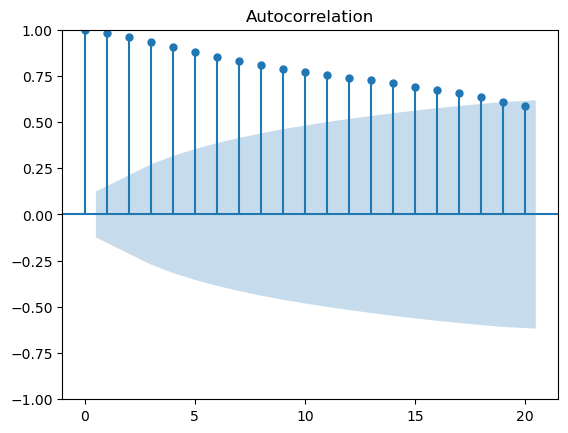

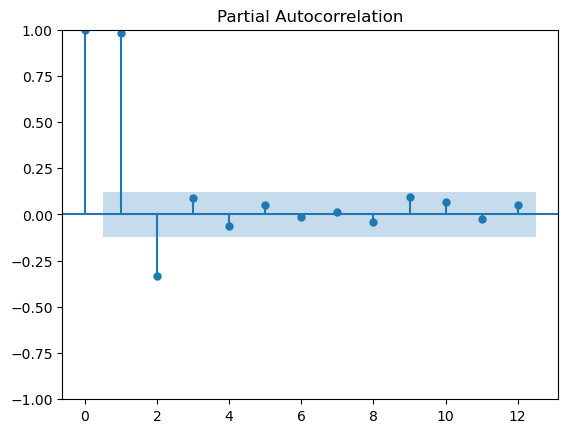

In [17]:
plot_acf(down_sample.Ex_rate,lags=20)# it will show many lags because in some way or other they r related to original time series but it creATES MULTICOLLINIARITY PROBLEM
plot_pacf(down_sample.Ex_rate,lags=12)#pacf=how many lags are actually impacting time series after removing noice . it prevents multicollinearity problem while doing autoregression
#PACF plot as it subtracts variations already explained by earlier lags,
plt.show()

# Data driven Models

In [45]:
len(currency)

7588

In [63]:
# train test split
train = currency.head(5588)
test = currency.tail(2000)

In [64]:
def MAPE(pred,org):
    temp = np.abs((pred-org)/org)*100
    return np.mean(temp)

# Simple Exponential Method

In [48]:
train["Ex_rate"] = train["Ex_rate"].astype('double')
test["Ex_rate"] = test["Ex_rate"].astype('double') 
ses_model = SimpleExpSmoothing(train["Ex_rate"]).fit(smoothing_level=0.8)
pred_ses = ses_model.predict(start = test.index[0],end = test.index[-1])
pred_ = ses_model.predict(start = train.index[0],end = train.index[-1])
print('test error',MAPE(pred_ses,test.Ex_rate,))
print(mean_absolute_percentage_error(test.Ex_rate,pred_ses)*100)
print('train error',MAPE(pred_,train.Ex_rate,))

test error 16.196165728539793
16.196165728539793
train error 0.5085498250661719


C:\Users\dushy\AppData\Local\Temp\ipykernel_11604\545733658.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["Ex_rate"] = train["Ex_rate"].astype('double')
C:\Users\dushy\AppData\Local\Temp\ipykernel_11604\545733658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Ex_rate"] = test["Ex_rate"].astype('double')
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._ini

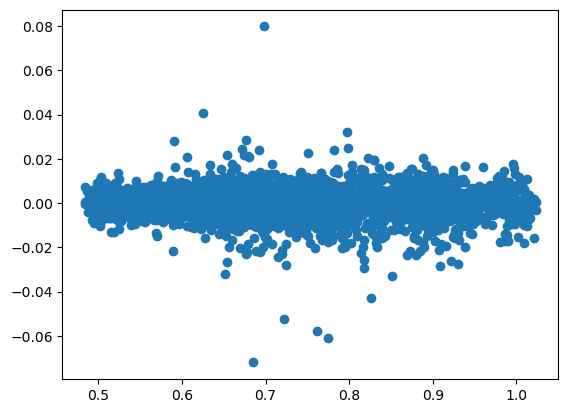

In [49]:
residuals = ses_model.resid
plt.scatter(ses_model.fittedvalues,residuals)

# Holt method

In [50]:
# Holt method 
hw_model = Holt(train["Ex_rate"],exponential=True,damped_trend=True).fit(smoothing_level=0.2, smoothing_slope=0.1)
pred_hw = hw_model.predict(start = test.index[0],end = test.index[-1])
pred_ = hw_model.predict(start = train.index[0],end = train.index[-1])
print('test error : ',MAPE(pred_hw,test.Ex_rate))
print('train error : ',MAPE(pred_,train.Ex_rate))

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\dushy\AppData\Local\Temp\ipykernel_11604\3395013639.py:2: FutureWarning: the 'smoothing_slope' keyword is deprecated, use 'smoothing_trend' instead.
  hw_model = Holt(train["Ex_rate"],exponential=True,damped_trend=True).fit(smoothing_level=0.2, smoothing_slope=0.1)


test error :  15.93124063462804
train error :  0.839244764136487


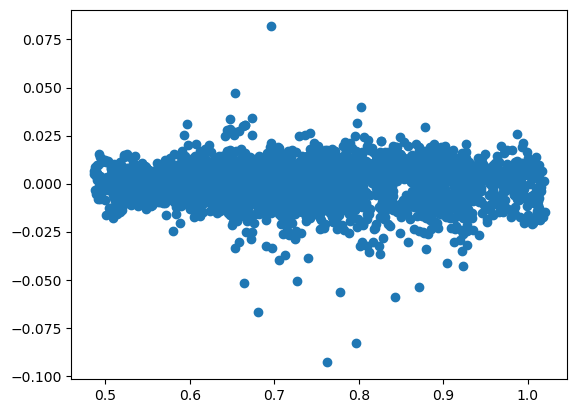

In [51]:
plt.scatter(hw_model.fittedvalues,hw_model.resid)

# Holts winter exponential smoothing with additive seasonality and additive trend

In [52]:
hwe_model_add_add = ExponentialSmoothing(train["Ex_rate"],damped_trend=True,seasonal="add",trend="add",seasonal_periods=360,freq='D').fit() #add the trend to the model
pred_hwe_mul_add = hwe_model_add_add.predict(start = test.index[0],end = test.index[-1])
print('Test error :',MAPE(pred_hwe_mul_add,test["Ex_rate"]))
pred_hwe_mul = hwe_model_add_add.predict(start = train.index[0],end = train.index[-1])
print('train error :',MAPE(pred_hwe_mul,train["Ex_rate"]))

Test error : 16.05191196200954
train error : 0.49607566148588195


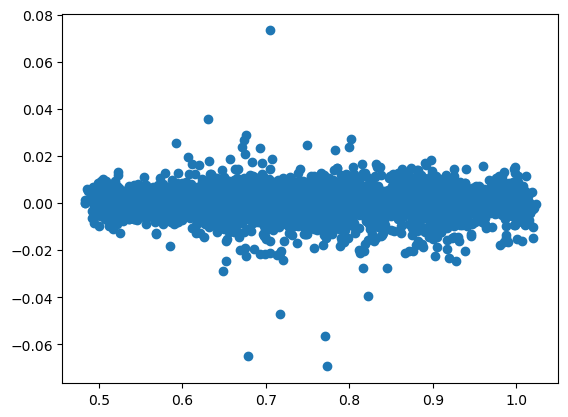

In [53]:
plt.scatter(hwe_model_add_add.fittedvalues,hwe_model_add_add.resid)

# final model in Data driven models

In [54]:
currency["Ex_rate"] = currency["Ex_rate"].astype('double')
hwe_model_mul_mul = ExponentialSmoothing(currency["Ex_rate"],damped_trend=True,seasonal="add",trend="add",seasonal_periods=360,freq='D').fit() 

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\holtwinters\model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [55]:
original = pred_hwe_mul_add
forcast = hwe_model_mul_mul.predict(start=len(train)+len(test),end=len(train)+len(test)+365)

<Axes: xlabel='date'>

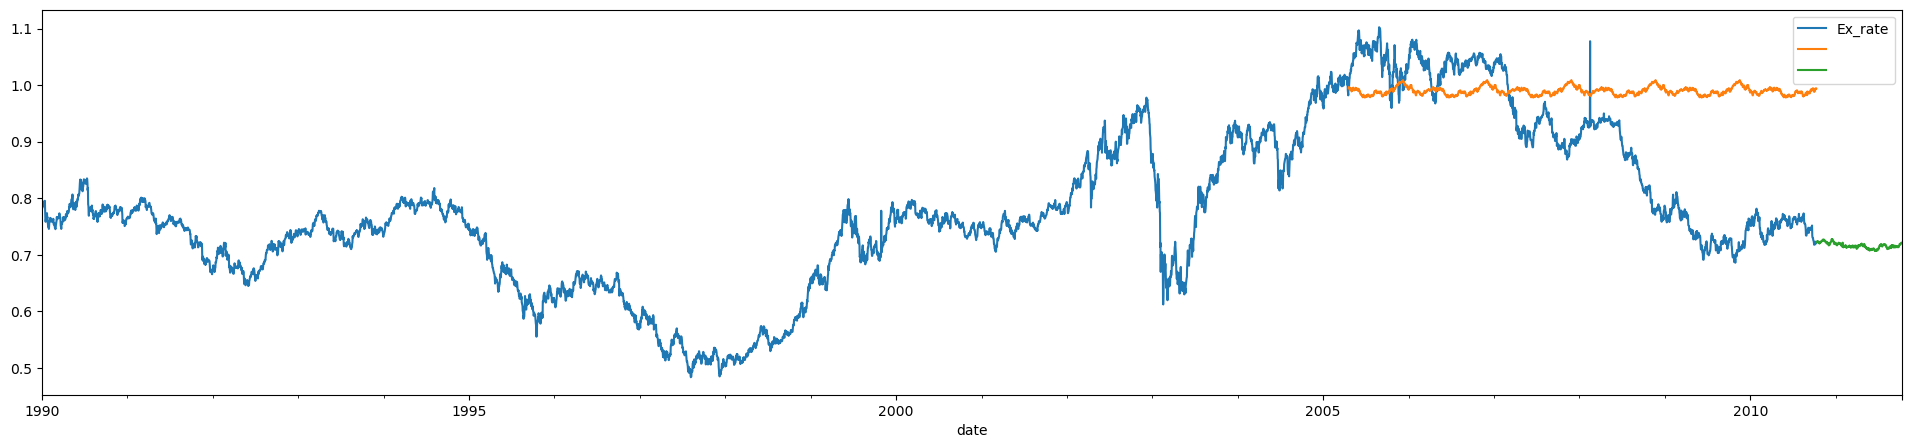

In [56]:
currency.plot(figsize = (24, 5), legend = True)
original.plot(legend=True)
forcast.plot(legend=True)

# ARIMA model

In [75]:
stepwise_fit = auto_arima(train['Ex_rate'], start_p = 1, start_q =1,
                          max_p = 3, max_q = 3,m=1,# seasonality is there so we mentioned m
                          start_P = 0, seasonal = True,
                          d = 1, D = 1, trace = True,
                          error_action ='ignore', # we don't want to know if an order does not work
                          suppress_warnings = True, # we don't want convergence warnings
                          stepwise = False,n_jobs=-1,n_fits=3) # set to stepwise



Best model:  ARIMA(3,1,2)(0,0,0)[1] intercept
Total fit time: 28.511 seconds


C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


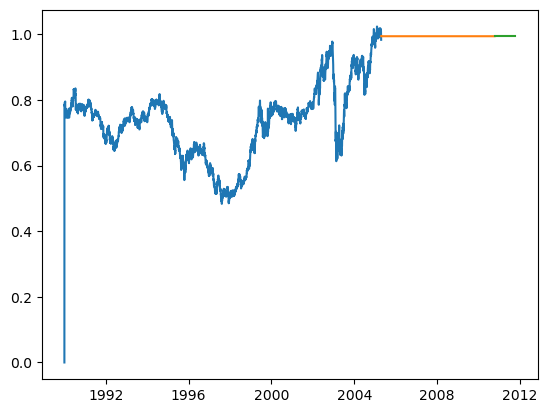

In [76]:
model = ARIMA(train,order=(3,1,2)).fit()
#plt.plot(train)
plt.plot(model.fittedvalues)
plt.plot(model.predict(start=test.index[0],end=test.index[-1]))
plt.plot(model.predict(start=len(train)+len(test),end=len(train)+len(test)+365))
plt.show()